# ** Creating the sliding window plot** 
- this script will get you 
    - the dna after 600k gens (6x coverage; as determined with avMut sims at the start of equilbiurm) 
    - window size 1000
    - stderr ribbon around the window values
        - note the stderr is the stderr b/t trials 
    - the mean and stderr ribbon for overal exon mutability 
        - note that this mean weights the mutability of each exon ewually: not accounting for length) 
        - (same for intron) 
    - all of the above for non CpGs too 
        - basically replace any CpG value with the average of non-CpG mutabilities 

** imports and global object creation ** 

In [4]:
import matplotlib.pyplot as plt
import numpy
import json
import numpy.random
import copy
import numpy as np 
from datetime import datetime #for plotting 
from tqdm import tqdm

In [5]:
plt.style.use('seaborn-ticks')

** reading in objects **

In [6]:
#doubled model genome wide
model = json.load(open("../Human_mutability_model/Model_2020_12_02_genomeWide.txt"))

In [7]:
file_path_initial = "data/same_DNA/"
sim_name_initial = "Files_to_use_for_parallel"

file_path_afterSim = "data/same_DNA/"
sim_name_afterSim = "Trial"

about_sim = "_cds_invariant50"
nTrials = 10

In [8]:
cds_pos_dictionary = open(file_path_initial+sim_name_initial+"_exon_insertion_dict.txt").readlines()[0]
cds_pos_dictionary = json.loads(cds_pos_dictionary)
cds_seq_dictionary = open(file_path_initial+sim_name_initial+"_exons_toUseSeqeunce_dict.txt").readlines()[0]
cds_seq_dictionary = json.loads(cds_seq_dictionary)

In [9]:
file_name = "Files_to_use_for_parallel_DNA_gen0_cds.txt"
DNAI = open(file_path_initial+file_name).readlines()[0]

In [10]:
DNAF_dataDict = {}
#note I want the dna string to be an entry in the list value fo the DNAF dictionary so i can add weigths later 
n_gens = 200000
for index_tmp in range(1,nTrials+1):
    file_name = sim_name_afterSim+str(index_tmp)+"_DNA_final"+about_sim+"_{g}.txt".format(g=n_gens)
    DNAF_dataDict["Trial"+str(index_tmp)] = [open(file_path_afterSim+file_name).readlines()[0]]

In [11]:
len(DNAF_dataDict["Trial1"])

1

** adding th mutability list to the DNAF_datatDict ** 

In [12]:
for trial_number in range(1, nTrials+1): 
    trial_name = "Trial"+str(trial_number)
    trial_weights = []
    for i in range(1, len(DNAF_dataDict[trial_name][0])-1):
        triplet = DNAF_dataDict[trial_name][0][i-1:i+2]
        trial_weights.append(model[triplet][0])
    DNAF_dataDict[trial_name].append(trial_weights)

# ** Getting average window value for each sample, then averaging/sd across samples ** 

In [13]:
window_size = 1000

In [14]:
sliding_window_X = []

for i in range(0,len(DNAI), window_size):                                  # 1[len(dnai)] iterating by window size 
    if len(DNAI) - i > window_size:                                        # if you're not RIGHT at the end 
        sliding_window_X.append(i+int(window_size/2)) 

In [15]:
# now want to append every average window mut value to the dnafplus dict 

for trial_number in range(1,nTrials): 
    trial_name = "Trial"+str(trial_number)
    
    trial_muts_list = []
    for i in range(0,len(DNAI), window_size):
        if len(DNAI) - i > window_size: 
            
            av_mut = np.mean(DNAF_dataDict[trial_name][1][i:i+window_size])
            trial_muts_list.append(av_mut)
                
        else: 
            print("size of omitted section is : "+str(len(DNAI)-i))
    DNAF_dataDict[trial_name].append(trial_muts_list)
    

size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145


In [16]:
len(DNAF_dataDict[trial_name])

3

** adding the window size mutability averages to the dictionary ** 

In [17]:
# creating the average muts and std list 
sliding_window_avMut = []
sliding_window_SE = []

nwindows = len(DNAF_dataDict["Trial1"][2])

for i in range(0,nwindows):
    window_muts = []

    for trial_number in range(1,nTrials): 
        trial_name = "Trial"+str(trial_number)
        window_muts.append(DNAF_dataDict[trial_name][2][i])
    
    sliding_window_avMut.append(np.mean(window_muts))
    sliding_window_SE.append(np.std(window_muts)/np.sqrt(nTrials))
    

** making the vectors to plot with plt ** 

In [18]:
sliding_belowError =  []
sliding_aboveError = []
for avMut, stderr in zip(sliding_window_avMut, sliding_window_SE): 
    sliding_belowError.append(avMut-stderr)
    sliding_aboveError.append(avMut+stderr)
sliding_belowError = np.array(sliding_belowError)
sliding_aboveError = np.array(sliding_aboveError)

** this is a double check to make sure the exons are when I think they are ** 

In [19]:
#do a double check after file imports 
for gene_id, gene_value in cds_seq_dictionary.items():     
    if DNAI.find(gene_value[0]) != cds_pos_dictionary[gene_id][0]+1: 
        print("ERROR: cds_pos_dict not accurate for this dna for "+gene_id)


** create a list of cds positions for plotting** 

In [20]:
cds_pos_list = []
for value in cds_pos_dictionary.values(): 
    cds_pos_list.extend([value[0], value[1]])
cds_pos_list.sort()

### ** OK NOW GET HORZONTAL MEAN VALUE (ALL INTRON, ALL EXON ) ** 

** EXON** 

In [21]:
#this list that will gather the mean mutability for all trials (len 10) (each string has mean mut for all its exons) 
exon_mean_mut = []
for i in tqdm(range(1,nTrials+1)):
    trial_name = "Trial"+str(i)
    exon_muts = []
    exon_means = []
    for exon in (cds_pos_dictionary.values()): #for each exon in the string (bounds are in the cds pos dicitonary)
        start = exon[0] #setting the bounds 
        end = exon[1]
        for j in range(start+1,end-2): #collect all the triplets in that region and add the mutability to exon_muts
            triplet = DNAF_dataDict[trial_name][0][j-1: j+2]
            exon_muts.append(model[triplet][0])
        exon_means.append(np.mean(exon_muts)) # for each exon, add the overall exon mean to exon_means 
    exon_mean_mut.append(np.mean(exon_means))#for each trial, add the overall trail mean to exon_mean_mut 

#exon_mean_mut is now a slist len ==10 containing the av mut for each trial. 
mean_exon_mut = np.mean(exon_mean_mut)
std_exon_mut = np.std(exon_mean_mut)
stderr_exon_mut = np.std(exon_mean_mut)/np.sqrt(nTrials)

100%|██████████| 10/10 [00:00<00:00, 27.79it/s]


In [22]:
print("mean exon mut = ", mean_exon_mut, "stderr exon mut=  ", stderr_exon_mut) 

mean exon mut =  3.4574859227787605e-05 stderr exon mut=   4.752947028125075e-08


** INTRON** 

In [23]:
#this list that will gather the mean mutability for all trials (len 10) (each string has mean mut for all its introns) 
intron_mean_mut = []
for i in tqdm(range(1,nTrials+1)):
    intron_start = 1
    trial_name = "Trial"+str(i)
    intron_muts = []
    intron_means = []
    for j in range(0, len(cds_pos_list), 2): #the cds_pos dict was converted into a list, here here we want to iterate it by 2 
        start = cds_pos_list[j] #start of the exon 
        end = cds_pos_list[j+1] #end of the exon 
        for k in range(intron_start,start): #analyze triplets from previous exon end to this intron start 
            triplet = DNAF_dataDict[trial_name][0][k-1: k+2]
            intron_muts.append(model[triplet][0])
        intron_start = end #update the "intron starting value" with the end of the current intron
        intron_means.append(np.mean(intron_muts))#for each intron, append the avergae to intron_means
    intron_mean_mut.append(np.mean(intron_means)) #for each trial, append the mean to intron_mean_mut
    

#intron_mean_mut is now a slist len ==10 containing the av mut for each trial. 
mean_intron_mut = np.mean(intron_mean_mut)
std_intron_mut = np.std(intron_mean_mut)
stderr_intron_mut = np.std(intron_mean_mut)/np.sqrt(nTrials)

100%|██████████| 10/10 [00:00<00:00, 26.92it/s]


In [24]:
print("mean intrn mut = ", mean_intron_mut, "stderr intron mut=  ", stderr_intron_mut) 

mean intrn mut =  2.9244799828375013e-05 stderr intron mut=   3.992012157998018e-08


** difference exon/intron** 

In [25]:
diff_exon_intro = []
for e,i in zip(exon_mean_mut, intron_mean_mut): 
    diff_exon_intro.append(e/i)

In [26]:
np.mean(diff_exon_intro), np.std(diff_exon_intro)

(1.1822823558427333, 0.007820672166946985)

** converting the exona nd itnron mean error into a vector that plt can plot as a ribbon ** 

In [27]:
exon_below_error = []
exon_above_error = []
intron_below_error = []
intron_above_error = []
for element in sliding_window_X: 
    exon_below_error.append(mean_exon_mut-stderr_exon_mut)
    exon_above_error.append(mean_exon_mut+stderr_exon_mut)
    intron_below_error.append(mean_intron_mut-stderr_intron_mut)
    intron_above_error.append(mean_intron_mut+stderr_intron_mut)

** making the x axis kbp units ** 

In [28]:
sliding_window_X_kb = [a/1000 for a in sliding_window_X]

** plotting ** 

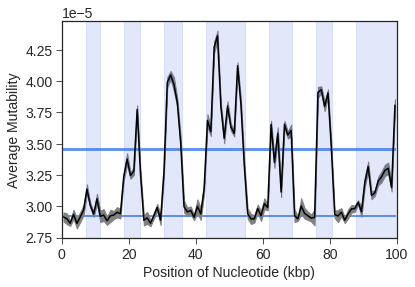

In [44]:
#details you want to be in graph titles
sim_details = "n = 12"

#this chunck is just plotting
fig, ax = plt.subplots()
plt.plot(sliding_window_X_kb, sliding_window_avMut, "black")

#x and y axis and aesthetic ticks 
plt.xlabel("Position of Nucleotide (kbp)")
plt.ylabel("Mutability")
plt.xticks([0,20,40,60,80,100])
plt.xlim(left = 0, right=100) 
plt.ticklabel_format(axis="y", style="sci",  scilimits=(0,0)) #e^-n format 

# LINES SHOWING WHERE THE CODING AND NON-CODING REGIONS ARE 
for index in range(0,len(cds_pos_list), 2): 
    ax.axvspan(cds_pos_list[index]/1000, cds_pos_list[index+1]/1000, alpha=.15, color='royalblue')
ax.grid(False)

#adjusting font size 
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
# plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize

#adding average exon / intron mutability horizontal ribbons 
plt.fill_between(sliding_window_X_kb,exon_below_error,exon_above_error, color = "cornflowerblue", label = "Exon")
plt.fill_between(sliding_window_X_kb,intron_below_error,intron_above_error, color = "cornflowerblue", label = "Intron")
#adding in SD 
plt.fill_between(sliding_window_X_kb,sliding_belowError,sliding_aboveError, color = "grey")

plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
# plt.savefig("plots/Sliding_{t}_Finalized_avCodingNonCoding_{g}.png".format(t = timestamp, g = n_gens))

In [31]:
print("exon     ", mean_exon_mut, stderr_exon_mut)
print("intron   ", mean_intron_mut, stderr_intron_mut)

exon      3.4574859227787605e-05 4.752947028125075e-08
intron    2.9244799828375013e-05 3.992012157998018e-08


# ** NON CPGS ** ~~~~~~~~~~~~~~~~~~~~~~~~~~~

In [32]:
muts = []
for mut in model.values(): 
    muts.append(mut[0])

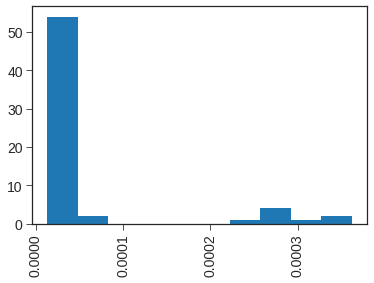

In [33]:
plt.hist(muts)
plt.xticks(rotation = 90)
plt.show()

In [34]:
#use the histogram above to find the right sperating value 
cpg_muts = []
non_cpg_muts = []
for key, value in model.items(): 
    if value[0] >= 0.0002 : 
        print(key, value[0])
        cpg_muts.append(value[0])
    else: 
        non_cpg_muts.append(value[0])

GCG 0.00029305478867835234
CGG 0.0002844044368929987
CCG 0.00028532665311129646
CGC 0.0002917845917779848
CGT 0.00035917531250873904
CGA 0.00026243687166486475
ACG 0.00036217158636308954
TCG 0.0002461141623593142


In [35]:
np.mean(non_cpg_muts)

2.7390179270981408e-05

** getting the non-cpg weights ** 

In [36]:
weights_initial_noCpg = []
cpg_initial_counter = 0
for index, weight in enumerate(weights_initial):  
    if weight in cpg_muts: 
        cpg_initial_counter += 1
        weights_initial_noCpg.append(0.45)
    else: 
        weights_initial_noCpg.append(weight)
        

NameError: name 'weights_initial' is not defined

In [37]:
DNAF_dataDict_noCPGMuts = {}
for key, value in DNAF_dataDict.items(): 
    trial_muts = []
    for weight in value[1]: 
        if weight in cpg_muts: 
            trial_muts.append(np.mean(non_cpg_muts))
        else: 
            trial_muts.append(weight)
    DNAF_dataDict_noCPGMuts[key] = [trial_muts]
    

** adding the window size mutability averages to the dictionary ** 

In [145]:
# now want to append every average window mut value to the dnafplus dict 

for trial_number in range(1,nTrials): 
    trial_name = "Trial"+str(trial_number)
    
    trial_muts_list = []
    for i in range(0,len(DNAI), window_size):
        if len(DNAI) - i > window_size: 
            
            av_mut = np.mean(DNAF_dataDict_noCPGMuts[trial_name][0][i:i+window_size])
            trial_muts_list.append(av_mut)
                
        else: 
            print("size of omitted section is : "+str(len(DNAI)-i))
    DNAF_dataDict_noCPGMuts[trial_name].append(trial_muts_list)
    

size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145
size of omitted section is : 145


** adding the window size mutability averages to the dictionary ** 

In [147]:
# creating the average muts and std list 
sliding_window_avMut_noCpg = []
sliding_window_SE_noCpg = []

nwindows = len(DNAF_dataDict_noCPGMuts["Trial1"][1])

for i in range(0,nwindows):
    window_muts = []

    for trial_number in range(1,nTrials): 
        trial_name = "Trial"+str(trial_number)
        window_muts.append(DNAF_dataDict_noCPGMuts[trial_name][1][i])
    
    sliding_window_avMut_noCpg.append(np.mean(window_muts))
    sliding_window_SE_noCpg.append(np.std(window_muts)/np.sqrt(nTrials))
    

** making the vectors to plot with plt ** 

In [149]:
sliding_belowError_noCpg =  []
sliding_aboveError_noCpg = []
for avMut, stderr in zip(sliding_window_avMut_noCpg, sliding_window_SE_noCpg): 
    sliding_belowError_noCpg.append(avMut-stderr)
    sliding_aboveError_noCpg.append(avMut+stderr)
sliding_belowError_noCpg = np.array(sliding_belowError_noCpg)
sliding_aboveError_noCpg = np.array(sliding_aboveError_noCpg)

### ** OK NOW GET HORZONTAL MEAN VALUE (ALL INTRON, ALL EXON ) ** 

** EXON** 

In [150]:
#this list that will gather the mean mutability for all trials (len 10) (each string has mean mut for all its exons) 
exon_mean_mut_noCpg = []
for i in tqdm(range(1,nTrials+1)):
    trial_name = "Trial"+str(i)
    exon_muts = []
    exon_means = []
    for exon in (cds_pos_dictionary.values()): #for each exon in the string (bounds are in the cds pos dicitonary)
        start = exon[0] #setting the bounds 
        end = exon[1]
        for j in range(start+1,end-2): #collect all the triplets in that region and add the mutability to exon_muts
            triplet = DNAF_dataDict[trial_name][0][j-1: j+2] # need to use the old dataDNAF dict as thats the one with rhe dna string
            mut = model[triplet][0]
            if mut in cpg_muts: 
                mut = np.mean(non_cpg_muts)
            exon_muts.append(mut)
        exon_means.append(np.mean(exon_muts)) # for each exon, add the overall exon mean to exon_means 
    exon_mean_mut_noCpg.append(np.mean(exon_means))#for each trial, add the overall trail mean to exon_mean_mut 

#exon_mean_mut is now a slist len ==10 containing the av mut for each trial. 
mean_exon_mut_noCpg = np.mean(exon_mean_mut_noCpg)
std_exon_mut_noCpg = np.std(exon_mean_mut_noCpg)
stderr_exon_mut_noCpg = np.std(exon_mean_mut_noCpg)/np.sqrt(nTrials)

100%|██████████| 10/10 [00:00<00:00, 14.12it/s]


In [151]:
print("mean exon mut = ", mean_exon_mut_noCpg, "stderr exon mut=  ", stderr_exon_mut_noCpg) 

mean exon mut =  2.70275207222e-05 stderr exon mut=   1.076310769e-08


** INTRON** 

In [152]:
#this list that will gather the mean mutability for all trials (len 10) (each string has mean mut for all its introns) 
intron_mean_mut_noCpg = []
for i in tqdm(range(1,nTrials+1)):
    intron_start = 1
    trial_name = "Trial"+str(i)
    intron_muts = []
    intron_means = []
    for j in range(0, len(cds_pos_list), 2): #the cds_pos dict was converted into a list, here here we want to iterate it by 2 
        start = cds_pos_list[j] #start of the exon 
        end = cds_pos_list[j+1] #end of the exon 
        for k in range(intron_start,start): #analyze triplets from previous exon end to this intron start 
            triplet = DNAF_dataDict[trial_name][0][k-1: k+2]# need to use the old dataDNAF dict as thats the one with rhe dna string
            mut = model[triplet][0]
            if mut in cpg_muts: 
                mut = np.mean(non_cpg_muts)
            intron_muts.append(mut)
        intron_start = end #update the "intron starting value" with the end of the current intron
        intron_means.append(np.mean(intron_muts))#for each intron, append the avergae to intron_means
    intron_mean_mut_noCpg.append(np.mean(intron_means)) #for each trial, append the mean to intron_mean_mut
    

#intron_mean_mut is now a slist len ==10 containing the av mut for each trial. 
mean_intron_mut_noCpg = np.mean(intron_mean_mut_noCpg)
std_intron_mut_noCpg = np.std(intron_mean_mut_noCpg)
stderr_intron_mut_noCpg = np.std(intron_mean_mut_noCpg)/np.sqrt(nTrials)

100%|██████████| 10/10 [00:00<00:00, 16.88it/s]


In [153]:
print("mean intrn mut = ", mean_intron_mut_noCpg, "stderr intron mut=  ", stderr_intron_mut_noCpg) 

mean intrn mut =  2.61102076216e-05 stderr intron mut=   1.07358810816e-08


In [143]:
print("mean intrn mut = ", mean_intron_mut, "stderr intron mut=  ", stderr_intron_mut) 

mean intrn mut =  2.91250370035e-05 stderr intron mut=   7.33671463586e-08


** converting the exona nd itnron mean error into a vector that plt can plot as a ribbon ** 

In [154]:
exon_below_error_noCpg = []
exon_above_error_noCpg = []
intron_below_error_noCpg = []
intron_above_error_noCpg = []
for element in sliding_window_X: 
    exon_below_error_noCpg.append(mean_exon_mut_noCpg-stderr_exon_mut_noCpg)
    exon_above_error_noCpg.append(mean_exon_mut_noCpg+stderr_exon_mut_noCpg)
    intron_below_error_noCpg.append(mean_intron_mut_noCpg-stderr_intron_mut_noCpg)
    intron_above_error_noCpg.append(mean_intron_mut_noCpg+stderr_intron_mut_noCpg)

** plotting ** 

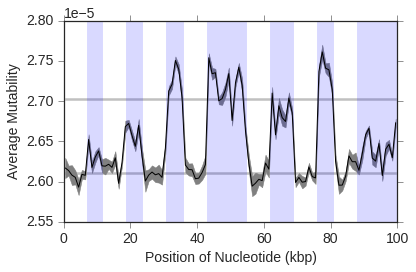

In [156]:
#this chunck is just plotting
fig, ax = plt.subplots()
plt.plot(sliding_window_X_kb, sliding_window_avMut_noCpg, "black")

#x and y axis and aesthetic ticks 
plt.xlabel("Position of Nucleotide (kbp)")
plt.ylabel("Average Mutability")
plt.xticks([0,20,40,60,80,100])
plt.xlim(left = 0, right=100) 
plt.ticklabel_format(axis="y", style="sci",  scilimits=(0,0)) #e^-n format 

# LINES SHOWING WHERE THE CODING AND NON-CODING REGIONS ARE 
for index in range(0,len(cds_pos_list), 2): 
    ax.axvspan(cds_pos_list[index]/1000, cds_pos_list[index+1]/1000, alpha=.15, color='blue')
ax.grid(False)

#adjusting font size 
SMALL_SIZE = 14
MEDIUM_SIZE = 14
BIGGER_SIZE = 18
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

#adding average exon / intron mutability horizontal ribbons 
plt.fill_between(sliding_window_X_kb,exon_below_error_noCpg,exon_above_error_noCpg, color = "silver", label = "Exon")
plt.fill_between(sliding_window_X_kb,intron_below_error_noCpg,intron_above_error_noCpg, color = "silver", label = "Intron")
#adding in SD 
plt.fill_between(sliding_window_X_kb,sliding_belowError_noCpg,sliding_aboveError_noCpg, color = "grey")

plt.show()
# timestamp = datetime.now().strftime("%Y/%m/%d_%H:%M:%S").replace("/", "_").replace(":", "_")
# plt.tight_layout()
# plt.savefig("plots/Sliding_{t}_Finalized_avCodingNonCoding_{g}_noCpG.png".format(t = timestamp, g = n_gens))